In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from multiprocessing import Pool
from functools import partial
import pickle
from scipy.interpolate import make_interp_spline

In [2]:
palette=['tab:blue', 'tab:green', 'tab:red']

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'Arial'

In [3]:
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

In [4]:
def seqDist(s1, s2):
    return sum([1 if b1 != b2 else 0 for b1, b2 in zip(s1, s2)])

In [5]:
def smoothOut(x, y):
    sp = make_interp_spline(x, y)
    X = np.linspace(min(x), max(x), 100)
    Y = sp(X)
    Y = [0 if j < 0 else j for j in Y]
    return X, Y

In [6]:
def compute_sample_distances(i, seqs, dist_function):
    '''
    
    '''
    results = []
    for j in range(i + 1, len(seqs)):
        edit_dist = dist_function(seqs[i], seqs[j])
        results.append((i, j, edit_dist))
    return results
    

In [7]:
def compute_dists(dist_function):
    '''
    
    '''
    partial_sample_dists = partial(compute_sample_distances,
                                   dist_function=dist_function,
                                   seqs=seqs)
    with Pool(8) as p:
        results_all = p.map(partial_sample_dists, list(range(len(seqs))))
        
    dist_mat = np.zeros((len(seqs), len(seqs)))
    for row_result in results_all:
        for i, j, dist in row_result:
            dist_mat[i, j] = dist
            dist_mat[j, i] = dist
    return dist_mat    

In [8]:
df = pd.read_csv('/home/jardic/Documents/projects/jk/datasets/datasets_prepped/strc_km.csv', index_col=0)

In [9]:
peak1 = 'AGACATGTTTTTTTAGTATGTTGT'
peak2 = 'AGAAATGTTTAGTATGTATGTTTT'

In [10]:
df_peak_dists = pd.DataFrame([[seqDist(s, peak1), seqDist(s, peak2)] for s in df['varseq']], columns=['peak1_dist', 'peak2_dist'])

In [11]:
cpm_thresholds = [(750, 20), (20, 3), (3, 0)]

for t in cpm_thresholds:
    print(len(df[df['cpm'].between(t[1], t[0])]))

df_high = df[df['cpm'].between(cpm_thresholds[0][1], cpm_thresholds[0][0])]
df_mid = df[df['cpm'].between(cpm_thresholds[1][1], cpm_thresholds[1][0])]
df_low = df[df['cpm'].between(cpm_thresholds[2][1], cpm_thresholds[2][0])]

2898
18465
7482430


In [12]:
distances_dist = []
for dfx in [df_high, df_mid, df_low]:
    # If there are more sequences than 5000, sample a random 5000 from this subset
    if len(dfx) > 1000:
        dfx = dfx.sample(1000)
    seqs = dfx['varseq'].tolist()
    ids = dfx.index.tolist()
    distances = pd.Series(compute_dists(seqDist).flatten()) 
    vcs_distances = distances.value_counts(normalize=True).sort_index()
    distances_dist.append(vcs_distances)

In [13]:
palette = ['#08415c', '#1a9643ff', '#cc2936']

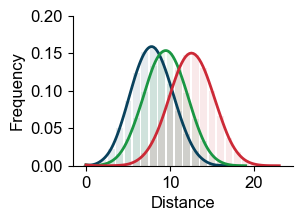

In [14]:
# Define absolute axis size in inches
axis_width = 2.2  # Width in inches
axis_height = 1.5  # Height in inches
w = 2
a = 0.1

# Define margins
left_margin = 0.5
bottom_margin = 0.5

# Compute figure size to ensure fixed axis size
fig_width = left_margin + axis_width + 0.5
fig_height = bottom_margin + axis_height + 0.5

fig = plt.figure(figsize=(fig_width, fig_height))

# Manually place the axes (left, bottom, width, height) in figure coordinates (0-1 range)
ax = fig.add_axes([
    left_margin / fig_width,
    bottom_margin / fig_height,
    axis_width / fig_width,
    axis_height / fig_height
])

for i in [0, 1, 2]:
    plt.bar(distances_dist[i].index, distances_dist[i].values, color=palette[i], alpha=a)
    line_thresholds = smoothOut(distances_dist[i].index, distances_dist[i].values)
    plt.plot(line_thresholds[0], line_thresholds[1], color=palette[i], linewidth=w)

sns.despine()

plt.xlabel('Distance')
plt.ylabel('Frequency')

#plt.xlim(-2, 25)
plt.ylim(0, 0.2)
#plt.xticks([0, 5, 10, 15])
#plt.yticks([0, 5, 10, 15])

sns.despine()
plt.savefig('pairwise_distances_distribution_2peaks.svg')

In [79]:
df_peak_separation = []
df_names = ['top', 'mid', 'bottom']

for n, dfx in enumerate([df_high, df_mid, df_low]):
    dfx = dfx.head(100)
    for i in dfx.index:
            row = df_peak_dists.loc[i]
            d1, d2 = row.min(), row.max()
            df_peak_separation.append([d1, d2, df_names[n]])

df_peak_separation = pd.DataFrame(df_peak_separation)
df_peak_separation.columns = ['min1', 'min2', 'topN']

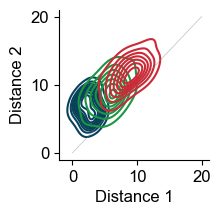

In [89]:
# Define absolute axis size in inches
axis_width = 1.5  # Width in inches
axis_height = 1.5  # Height in inches

# Define margins
left_margin = 0.5
bottom_margin = 0.5

# Compute figure size to ensure fixed axis size
fig_width = left_margin + axis_width + 0.5
fig_height = bottom_margin + axis_height + 0.5

fig = plt.figure(figsize=(fig_width, fig_height))

# Manually place the axes (left, bottom, width, height) in figure coordinates (0-1 range)
ax = fig.add_axes([
    left_margin / fig_width,
    bottom_margin / fig_height,
    axis_width / fig_width,
    axis_height / fig_height
])

# Plot
sns.kdeplot(data=df_peak_separation, x='min1', y='min2', hue='topN', common_norm=True, bw_adjust=1.5, fill=False, alpha=1, palette=palette, legend=False)
plt.plot([0, 20], [0, 20], color='grey', alpha=0.5, linewidth=0.5)


plt.xlabel('Distance 1')
plt.ylabel('Distance 2')


#plt.xlim(-2, 25)
#plt.xticks([0, 5, 10, 15])
#plt.yticks([0, 5, 10, 15])

sns.despine()
plt.savefig('peak_separation_2peaks_c8.svg')